In [19]:
import pandas as pd
import numpy as np
import re
import requests
import time

from bs4 import BeautifulSoup

def moveSibling(tag, number):
	i = 1
	while i <= number:
		tag = tag.nextSibling
		i += 1
	return tag

from matplotlib import pyplot as plt
%matplotlib inline

In [20]:
columns_dl = 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR', 'B365H', 'B365D', 'B365A'
downloaded_df = pd.DataFrame(data=None, columns=columns_dl)

In [21]:
for year in range(2006, 2017):
    y1 = str(year)[2:]
    y2 = str(year+1)[2:]
    url = "http://www.football-data.co.uk/mmz4281/" + y1 + y2 + "/D1.csv"
    df = pd.read_csv(url)
    df = df.loc[:, columns_dl]
    downloaded_df = downloaded_df.append(df)

In [22]:
seasonlist = [2006 + (i+1)/(9*34) for i in range(len(downloaded_df))]
gamedaylist = [1 + np.mod(i/9,34) for i in range(len(downloaded_df))]

In [23]:
downloaded_df.loc[:, "Season"] = seasonlist
downloaded_df.loc[:, "Gameday"] = gamedaylist

In [24]:
teamlist = downloaded_df.loc[:, "HomeTeam"].unique()
data = np.array([range(len(teamlist)), teamlist]).T
team_df = pd.DataFrame(data=data, columns=['TID', 'team'])

In [25]:
cleaned_df = pd.merge(team_df, downloaded_df, how='inner', left_on='team', right_on='HomeTeam')
cleaned_df = pd.merge(team_df, cleaned_df, how='inner', left_on='team', right_on='AwayTeam', suffixes=('_A', '_H'))

columns_cl = ['Season', 'Gameday', 'TID_H', 'TID_A', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR', 'B365H', 'B365D', 'B365A']
cleaned_df = cleaned_df.loc[:, columns_cl].sort_values(['Season', 'Gameday'])
cleaned_df.index = range(len(cleaned_df))

cleaned_df.to_csv('Bundesliga_Data_2006_2016.csv', index=False)
team_df = team_df.set_index('TID')

In [8]:
# Working Code to Download all Game Reports from Kicker

# for year in range(2005, 2017):
#     for gameday in range(1,35):
#         print year, gameday
#         url = "http://www.kicker.de/news/fussball/bundesliga/spieltag/1-bundesliga/"
#         url = url + str(year) + "-" + str(year+1)[2:4] + "/"
#         url = url + str(gameday) + "/0/spieltag.html"

#         website = requests.get(url)
#         main = BeautifulSoup(website.content, 'html.parser')
#         main_table = main.find('table', {'class': 'tStat', 'summary': 'Tabelle'})

#         # Once we get to the unplayed gamedays, no table will be displayed, and the loop shall end.
#         try:
#             main_standings = main_table.find_all('a', {'class': 'link verinsLinkBild'})
#         except:
#             break
            
#         main_matches = main.find('table', {'class': 'tStat tab1-bundesliga', 'summary': 'Begegnungen'})

#         # Find all links of class "link." These refer to the game analyses.
#         for game in main_matches.find_all('a', {'class' : 'link'}):
#             # result = game.parent.previous_sibling.previous_sibling.text
#             # result = map(int, result[0:result.find("(")-1].split(":"))

#             game_url = game.get('href')
#             encoded_in_url = game_url.split("/")

#             # Game ID is the article ID for kicker, as unique ID for game
#             game_id = encoded_in_url[8][0:7]

#             # Game URL encodes the teams which are playing
#             teams = encoded_in_url[9][13:-5].split("_")
#             teams = map(int, [teams[i][teams[i].rfind('-')+1:] for i in range(2)])

#             # URL to open individiual games
#             game_url = "http://www.kicker.de" + game_url

#             error_count = 0
#             while error_count < 3:
#                 try:
#                     game_file = requests.get(game_url)
#                     game_soup = BeautifulSoup(game_file.content, 'html.parser')
#                     filename = str(year) + "_"
#                     filename += ("0" + str(gameday))[-2:] + "_" 
#                     filename += str(teams[0]) + "-v-" + str(teams[1])
                    
#                     with open("game_reports/" + filename + "_main.html", 'w') as file:
#                         file.write(game_soup.encode('ISO-8859-1'))
#                         break
#                 except:
#                     error_count += 1

#             if error_count == 3:
#                 continue

In [26]:
try:
    kicker_grades_df = pd.read_csv('Grades_2005_2016.csv')
except:
    if input('Re-download? yes?') == 'yes':
        grade_row = []
        for year in range(2005, 2017):
            for gameday in range(1,35):
                print year, gameday
                url = "http://www.kicker.de/news/fussball/bundesliga/spieltag/1-bundesliga/"
                url = url + str(year) + "-" + str(year+1)[2:4] + "/"
                url = url + str(gameday) + "/0/spieltag.html"

                website = requests.get(url)
                main = BeautifulSoup(website.content, 'html.parser')
                main_table = main.find('table', {'class': 'tStat', 'summary': 'Tabelle'})

                # Once we get to the unplayed gamedays, no table will be displayed, and the loop shall end.
                try:
                    main_standings = main_table.find_all('a', {'class': 'link verinsLinkBild'})
                except:
                    break

                # If we didn't break, proceed as usual.

                main_matches = main.find('table', {'class': 'tStat tab1-bundesliga', 'summary': 'Begegnungen'})

                # Find all links of class "link." These refer to the game analyses.
                for game in main_matches.find_all('a', {'class' : 'link'}):
                    # result = game.parent.previous_sibling.previous_sibling.text
                    # result = map(int, result[0:result.find("(")-1].split(":"))

                    game_url = game.get('href')
                    encoded_in_url = game_url.split("/")

                    # Game ID is the article ID for kicker, as unique ID for game
                    game_id = encoded_in_url[8][0:7]

                    # Game URL encodes the teams which are playing
                    teams = encoded_in_url[9][13:-5].split("_")
                    teams = map(int, [teams[i][teams[i].rfind('-')+1:] for i in range(2)])

                    # URL to open individiual games
                    game_url = "http://www.kicker.de" + game_url
                    error_count = 0
                    while error_count < 10:
                        try:
                            game_file = requests.get(game_url)
                            game_soup = BeautifulSoup(game_file.content, 'html.parser')
                            game_soup.find('table', {'class': 'tStat', 'summary': 'Vereinsliste'}).find_all('div', {'class': 'aufstellung_team'})
                            break
                        except:
                            error_count += 1

                    if error_count == 10:
                        continue

                    i = 0
                    for lineup in game_soup.find('table', {'class': 'tStat', 'summary': 'Vereinsliste'}).find_all('div', {'class': 'aufstellung_team'}):
                        no_players = 0
                        grade = 0.
                        for player in lineup.find_all('a'):
                            grade_raw = unicode(player.next_sibling)

                            grade_del1 = unicode(grade_raw).find('(')
                            grade_del2 = unicode(grade_raw).find(')')

                            if grade_del1 == -1:
                                continue

                            grade += float(grade_raw[grade_del1+1:grade_del2].replace(",", "."))

                            no_players += 1
                            if no_players == 11:
                                break
                        grade = grade/no_players

                        grade_row += [[year, gameday, teams[np.mod(i,2)], grade]]
                        i += 1
    else:
        "Doing nothing. No df loaded."

try:
    kicker_grades_df = kicker_grades_df.drop('Unnamed: 0', axis=1)
except:
    print "Import Successful"

kicker_grades_df.head()

Import Successful


,Season,Gameday,KID,GradeAvg
0,2005,1,14,3.136364
1,2005,1,15,4.045455
2,2005,1,16,3.636364
3,2005,1,30,3.863636
4,2005,1,1,3.181818


In [27]:
kicker_grades_df.to_csv('Grades_2005_2016.csv', index=False)

In [29]:
try:
    key_df = pd.read_csv('Team_ID_hardcoded.csv')
    print "Import Successful"
except:
    team_list = []
    for year in range(2005,2017):
        url = 'http://www.kicker.de/news/fussball/bundesliga/vereine/1-bundesliga/'
        url += str(year) + '-' + str(year+1)[-2:]
        url += '/vereine-liste.html'

        website = requests.get(url)
        main = BeautifulSoup(website.content, 'html.parser')
        for team in main.find_all('a', {'class': 'link verinsLinkBild'}):
            team_name_id = team.get('href').split('/')[7]
            team_name = team_name_id[0:team_name_id.rfind("-")]
            team_id = team_name_id[team_name_id.rfind("-")+1:]
            team_list += [[int(team_id), team_name]]
            
    kicker_team_df = pd.DataFrame(data=team_list, columns=['KID', 'KName'])
    kicker_team_df = kicker_team_df.drop_duplicates().set_index('KID')
    
    print "Manual hard-coding of IDs necessary."
    # Then manually hardcode matching IDs

Import Successful


In [30]:
def rescale_grade(x):
    return 1 - (x-1.)/5

grades_df = kicker_grades_df.merge(key_df, how='left', left_on='KID', right_on='KID').loc[:, ('Season', 'Gameday','TID', 'GradeAvg')]
grades_df = grades_df.set_index(['TID', 'Season', 'Gameday']).sort_index()
grades_df = grades_df.apply(rescale_grade)

print grades_df.loc[:, 'GradeAvg'].min()
print grades_df.loc[:, 'GradeAvg'].max()

0.027272727272
0.845454545454


In [31]:
def inverse(x):
    return 1./x
def points(x):
    if x > 0:
        return 1
    elif x == 0:
        return 1./3
    else:
        return 0

In [32]:
complete_df = cleaned_df.merge(grades_df, how='inner', left_on=['TID_H', 'Season', 'Gameday'], right_index=True)
complete_df = complete_df.merge(grades_df, how='inner', left_on=['TID_A', 'Season', 'Gameday'], right_index=True)

complete_df = complete_df.rename(columns={'GradeAvg_x': 'HGA', 'GradeAvg_y': 'AGA'})
complete_df = complete_df.replace({'H':1, 'D':0.5, 'A':0})
complete_df.loc[:, 'FTGD'] = complete_df.loc[:, 'FTHG'] - complete_df.loc[:, 'FTAG']
complete_df.loc[:, 'HTGD'] = complete_df.loc[:, 'HTHG'] - complete_df.loc[:, 'HTAG']

complete_df.loc[:, 'Odds'] = (complete_df.filter(regex='^B365').apply(inverse)*(1,0.5,0)).apply(np.sum, axis=1)

complete_df.head()

,Season,Gameday,TID_H,TID_A,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,HR,AR,B365H,B365D,B365A,HGA,AGA,FTGD,HTGD,Odds
0,2006,1,6,9,0.0,3.0,0.0,0.0,2.0,0.0,...,0.0,0.0,2.00,3.2,3.75,0.309091,0.727273,-3.0,-2.0,0.656250
1,2006,1,2,10,3.0,0.0,1.0,2.0,0.0,1.0,...,1.0,1.0,1.44,4.0,7.50,0.654545,0.300000,3.0,2.0,0.819444
2,2006,1,4,11,2.0,0.0,1.0,0.0,0.0,0.5,...,0.0,1.0,1.61,3.6,5.50,0.545455,0.427273,2.0,0.0,0.760007
3,2006,1,0,12,2.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,1.57,3.6,6.00,0.654545,0.381818,2.0,1.0,0.775832
4,2006,1,5,13,1.0,1.0,0.5,1.0,0.0,1.0,...,0.0,0.0,1.44,4.0,7.50,0.581818,0.363636,0.0,1.0,0.819444


In [33]:
multi_index = pd.MultiIndex(levels=[[],[],[]],
                             labels=[[],[],[]],
                             names=[u'TID', u'Season', u'Gameday'])
table_df = pd.DataFrame(data=None, columns=['Points'], index=multi_index)


for tid in range(len(team_df)):
    query = 'TID_H == ' + str(tid)
    temp_H = complete_df.query(query).loc[:, ['TID_H', 'Season', 'Gameday', 'FTHG', 'FTAG']]
    temp_H.loc[:, 'Gameday'] += 1
    temp_H.loc[:, 'GD'] = temp_H.loc[:, 'FTHG'] - temp_H.loc[:, 'FTAG']
    temp_H = temp_H.set_index(['TID_H', 'Season', 'Gameday'])

    query = 'TID_A == ' + str(tid)
    temp_A = complete_df.query(query).loc[:, ['TID_A', 'Season', 'Gameday', 'FTHG', 'FTAG']]
    temp_A.loc[:, 'Gameday'] += 1
    temp_A.loc[:, 'GD'] = - temp_A.loc[:, 'FTHG'] + temp_A.loc[:, 'FTAG']
    temp_A = temp_A.set_index(['TID_A', 'Season', 'Gameday'])

    temp = pd.concat([temp_H, temp_A]).sort_index()
    temp.index = temp.index.rename(['TID', 'Season', 'Gameday'])
    temp.loc[:, 'Points'] = temp.loc[:, 'GD'].apply(points).to_frame()

    temp = temp.drop(['FTHG', 'FTAG'], axis=1)

    table_df = table_df.append(temp.groupby(level=['TID', 'Season'], group_keys=False).cumsum())

# Update most recent season such that we calculate it as if 34 Games have been played.

    idx = pd.IndexSlice
    table_extrap_df = table_df.groupby(level=['Season', 'TID']).mean()
    table_extrap_df.loc[idx[complete_df.iloc[-1, 0], :], :] = table_extrap_df.loc[idx[complete_df.iloc[-1, 0], :], :]* 34./complete_df.iloc[-1, 1]

In [34]:
multi_index = pd.MultiIndex(levels=[[],[],[]],
                             labels=[[],[],[]],
                             names=[u'TID', u'Season', u'Gameday'])
running_df = pd.DataFrame(data=None, columns=['Points'], index=multi_index)

for tid in range(len(key_df)):
    query = 'TID_H == ' + str(tid)
    temp_H = complete_df.query(query).loc[:, ['TID_H', 'Season', 'Gameday', 'FTHG', 'FTAG']]
    temp_H.loc[:, 'Gameday'] += 1
    temp_H.loc[:, 'GD'] = temp_H.loc[:, 'FTHG'] - temp_H.loc[:, 'FTAG']
    temp_H = temp_H.set_index(['TID_H', 'Season', 'Gameday'])

    query = 'TID_A == ' + str(tid)
    temp_A = complete_df.query(query).loc[:, ['TID_A', 'Season', 'Gameday', 'FTHG', 'FTAG']]
    temp_A.loc[:, 'Gameday'] += 1
    temp_A.loc[:, 'GD'] = - temp_A.loc[:, 'FTHG'] + temp_A.loc[:, 'FTAG']
    temp_A = temp_A.set_index(['TID_A', 'Season', 'Gameday'])

    temp = pd.concat([temp_H, temp_A]).sort_index()
    temp.index = temp.index.rename(['TID', 'Season', 'Gameday'])
    temp = temp.loc[:, 'GD'].apply(points).rename('Points').to_frame()
    
    running_df = running_df.append(temp.groupby(level=['TID', 'Season'], group_keys=False).rolling(3, 1).mean())

running_df.to_csv('Running_Points_2006_2016.csv')

In [35]:
complete_running_df = complete_df.merge(running_df, how='left', left_on=['TID_H', 'Season', 'Gameday'], right_index=True)
complete_running_df = complete_running_df.merge(running_df, how='left', left_on=['TID_A', 'Season', 'Gameday'], right_index=True)

complete_running_df = complete_running_df.rename(columns={'Points_x': 'HP3', 'Points_y': 'AP3'}).filter(regex='^(?!B365)')
complete_running_df = complete_running_df.drop(['FTAG', 'FTR','HTAG', 'HTR'], axis=1)

complete_running_df = complete_running_df.drop_duplicates(['Season', 'Gameday', 'TID_H', 'TID_A']).fillna(0.5)

In [36]:
complete_running_df.to_csv('All_Data_2006_2016.csv')
len(complete_running_df)

3174

In [37]:
complete_running_df.fillna(0.5).head()

,Season,Gameday,TID_H,TID_A,FTHG,HTHG,HS,AS,HST,AST,...,AY,HR,AR,HGA,AGA,FTGD,HTGD,Odds,HP3,AP3
0,2006,1,6,9,0.0,0.0,10.0,11.0,8.0,8.0,...,2.0,0.0,0.0,0.309091,0.727273,-3.0,-2.0,0.656250,0.5,0.5
1,2006,1,2,10,3.0,2.0,20.0,8.0,11.0,5.0,...,0.0,1.0,1.0,0.654545,0.300000,3.0,2.0,0.819444,0.5,0.5
2,2006,1,4,11,2.0,0.0,13.0,11.0,8.0,7.0,...,4.0,0.0,1.0,0.545455,0.427273,2.0,0.0,0.760007,0.5,0.5
3,2006,1,0,12,2.0,1.0,12.0,16.0,9.0,7.0,...,2.0,0.0,0.0,0.654545,0.381818,2.0,1.0,0.775832,0.5,0.5
4,2006,1,5,13,1.0,1.0,24.0,8.0,13.0,5.0,...,2.0,0.0,0.0,0.581818,0.363636,0.0,1.0,0.819444,0.5,0.5


In [38]:
# Shots on target per attempt
print complete_running_df.loc[:, ['HST', 'AST', 'HS', 'AS']].mean()


HST     5.572464
AST     4.486137
HS     14.611846
AS     11.815690
dtype: float64


In [39]:
shots = complete_running_df.loc[:, ['TID_H','Season', 'HST', 'AST', 'HS', 'AS']].groupby(['TID_H', 'Season']).mean()
conversion_df = shots
conversion_df.loc[:, 'HEff'] = np.round(100*conversion_df.loc[:, 'HST'] / conversion_df.loc[:, 'HS'], 1)
conversion_df.loc[:, 'AEff'] = np.round(100*conversion_df.loc[:, 'AST'] / conversion_df.loc[:, 'AS'], 1)

print conversion_df.loc[:, ['HEff', 'AEff']].mean()
#conversion_df.index = conversion_df.set_index(range(len(conversion_df)))


HEff    37.715657
AEff    37.802020
dtype: float64


In [40]:
shots_H = complete_running_df.loc[:, ['TID_H', 'HST', 'AST', 'HS', 'AS']].groupby('TID_H').mean()
conversion_df_H = shots_H.merge(team_df, left_index=True, right_index=True).set_index('team')
conversion_df_H.loc[:, 'HEff'] = np.round(100*conversion_df_H.loc[:, 'HST'] / conversion_df_H.loc[:, 'HS'], 1)
conversion_df_H.loc[:, 'AEff'] = np.round(100*conversion_df_H.loc[:, 'AST'] / conversion_df_H.loc[:, 'AS'], 1)

shots_A = complete_running_df.loc[:, ['TID_A', 'HST', 'AST', 'HS', 'AS']].groupby('TID_A').mean()
conversion_df_A = shots_A.merge(team_df, left_index=True, right_index=True).set_index('team')
conversion_df_A.loc[:, 'HEff'] = np.round(100*conversion_df_A.loc[:, 'HST'] / conversion_df_A.loc[:, 'HS'], 1)
conversion_df_A.loc[:, 'AEff'] = np.round(100*conversion_df_A.loc[:, 'AST'] / conversion_df_A.loc[:, 'AS'], 1)

shots = pd.merge(
    conversion_df_H.loc[:, ['HS', 'HST', 'HEff', 'AS', 'AST', 'AEff']], 
    conversion_df_A.loc[:, ['HS', 'HST', 'HEff', 'AS', 'AST', 'AEff']],
    how='inner', left_index=True, right_index=True, suffixes=('_as_H', '_as_A')).apply(np.round, args=(2,))
#shots.index = team_df.loc[:, 'team']
shots.loc[:, 'Ratio_as_H'] = shots.loc[:, 'HEff_as_H'] / shots.loc[:, 'AEff_as_H']
shots.loc[:, 'Ratio_as_A'] = shots.loc[:, 'AEff_as_A'] / shots.loc[:, 'HEff_as_A']

shots.ix[:, ['Ratio_as_H', 'Ratio_as_A']]


,Ratio_as_H,Ratio_as_A
team,,
Bayern Munich,1.145161,1.162393
Hamburg,0.992268,0.965789
Leverkusen,1.048000,1.023316
Mainz,1.000000,1.002611
M'gladbach,1.140845,1.052055
Schalke 04,1.117647,1.073569
Stuttgart,0.994885,1.023438
Hannover,0.997449,0.846715
Wolfsburg,1.035990,1.012953


In [41]:
point_avg_df = table_extrap_df.groupby(level=['TID']).mean()
point_avg_df.index = shots.index

factors_df = pd.merge(point_avg_df, shots, how='inner', left_index=True, right_index=True)
factors_df.loc[:, 'Ratio_Mean'] = 0.5 * (factors_df.loc[:, 'Ratio_as_H'] + factors_df.loc[:, 'Ratio_as_A']).astype(float)
factors_df.loc[:, 'Eff_Mean'] = 0.5 * (factors_df.loc[:, 'HEff_as_H'] + factors_df.loc[:, 'AEff_as_A'])


In [42]:
point_avg_df.head()

,GD,Points
team,,
Bayern Munich,27.214663,13.149638
Hamburg,-4.501804,7.287457
Leverkusen,8.845885,9.959028
Mainz,-1.184949,8.045653
M'gladbach,-1.063136,7.856849


In [ ]:
matches_df = pd.read_csv("Matches_2005_2016.csv")
#goals_df = pd.read_csv
#lineup_df.

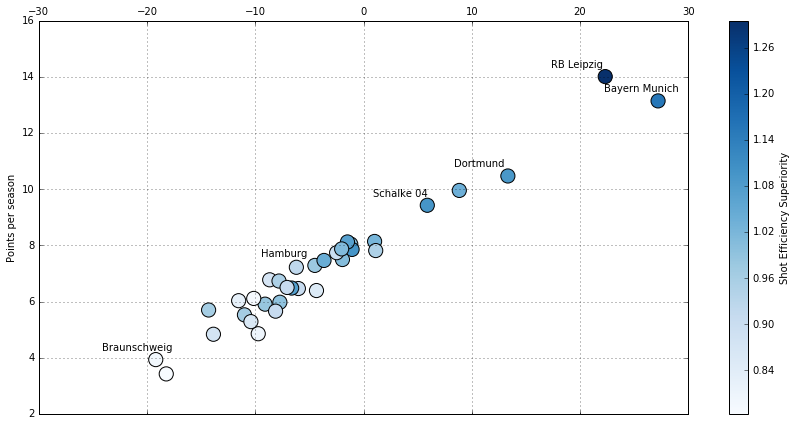

In [43]:
ax = factors_df.plot(kind='scatter', x='GD', y='Points', s=200, c='Ratio_Mean', colormap='Blues', figsize=(12,6), grid=True)

plt.xlabel('Avg. goal differential')
plt.ylabel('Points per season')


ax.tick_params(labelbottom='off',labeltop='on')
ax.xaxis.set_label_position('top') 
plt.tight_layout()

for i in [0,1, 12, 29, 5,33]:
    ax.annotate(factors_df.index[i], (-5+factors_df.ix[i, 'GD'], 0.32+factors_df.ix[i, 'Points']))

# Grab colorbar object    
cax = plt.gcf().get_axes()[1]
cax.set_ylabel('Shot Efficiency Superiority')

In [111]:
# complete_df.plot(kind='scatter', x='HGA', y='FTGD')
# complete_df.plot(kind='scatter', x='AGA', y='FTGD')
# complete_running_df.plot.hexbin(x='HGA', y='AGA', gridsize=20)
# complete_running_df.plot.hexbin(x='HGA', y='AGA', C='Odds', gridsize=20)

In [ ]:
# complete_running_df.loc[:, ['Season', 'HGA', 'AGA']].groupby('Season').mean().plot()
# complete_running_df.loc[:, ['Season', 'FTGD', 'HTGD']].groupby('Season').mean().plot()
# (complete_running_df.loc[:, ['Season', 'FTGD', 'HTGD']].groupby('Season').std()*(1,np.sqrt(2.))).plot()

# complete_df.plot.hexbin(x='Odds', y='FTGD', gridsize=15)

In [ ]:
# Working code to read data from Kicker.de

# matches_columns = ['Season', 'Gameday', 'Link', 'TeamH', 'TeamA',
#            'GoalsH', 'ShotsH', 'PassesH', 'PassQuH', 'PossesH', 'ChallH', 'FoulsH', 'OffsideH', 'CornersH', 'ChancesH',
#            'GoalsA', 'ShotsA', 'PassesA', 'PassQuA', 'PossesA', 'ChallA', 'FoulsA', 'OffsideA', 'CornersA', 'ChancesA',
#            'Attendance']
# matches_df = pd.DataFrame(data=None, columns=matches_columns)

# # Table for goal information, can be linked through "Link" with game info
# goals_columns = ['Season', 'Gameday', 'Link', 'Score', 'Minute', 'Player']
# goals_df = pd.DataFrame(data=None, columns=goals_columns)

# # Table for Starting 11
# lineup_columns = ["Link"] + ["Home_Player" + ("0" + str(i))[-2:] for i in range(1,12)] + ["Away_Player" + ("0" + str(i))[-2:] for i in range(1,12)]
# lineup_df = pd.DataFrame(data=None, columns=lineup_columns)

# i = 0 

# for filename in listdir("./game_reports/"):
#     if str(filename)[0] != "2":
#         continue
#     try:
#         game_soup = BeautifulSoup(open("./game_reports/" + filename))
#     except:
#         print "Print file not found"
#         continue
    
#     game_info = str(filename).split("_")[0:3]
#     season = int(game_info[0])
#     gameday = int(game_info[1])
#     teams = game_info[2].split("-")
#     teams = map(int, [teams[0], teams[2]])

    
#     game_id = i
#     i += 1
    
#     error_count = 0
#     # Download lineups
#     try:
#         game_soup.find('table', {'class': 'tStat', 'summary': 'Vereinsliste'}).find_all('div', {'class': 'aufstellung_team'})
#         game_soup.find('table', {'class': 'tStat', 'summary': 'Tore & Karten'}).find('div', {'class': 'tore_karten'}).find_all('div', {'class': 'kompletteZeile'})
#     except:
#         while error_count < 3:
#             try:
#                 print "Reading error. Trying to open from URL."
#                 url = game_soup.find('meta', {'property': 'og:url'})
#                 url = url.attrs['content'] 
#                 print url
#                 file = requests.get(url)
#                 game_soup = BeautifulSoup(file.content, 'lxml')
#                 break
#             except:
#                 error_count += 1
            
#     if error_count < 3:
#         both_teams = game_soup.find('table', {'class': 'tStat', 'summary': 'Vereinsliste'})
#         lineup = []
#         for one_team in both_teams.find_all('div', {'class': 'aufstellung_team'}):
#             for player in one_team.find_all('a', {'class': 'link_noicon'}):
#                 lineup.append(player.get('href').split("/")[8])
#                 # Make sure to only download the first 11, the Starting 11, for each team
#                 if np.mod(len(lineup), 11) == 0:
#                     break
#         lineup = [game_id] + map(int, lineup)
#     else:
#         print "Error in reading and opening for " + game_soup.find('title').text
#         lineup = [game_id] + [np.nan for _ in range(22)]

#     lineup_df = lineup_df.append(pd.DataFrame(data=[lineup], columns=lineup_columns), ignore_index=True)

#     # Download main stats and save in a list.
#     stats = game_soup.find('table', {'class': 'tStat tStatKarten', 'summary': 'Berufungen'})
#     team1_stats = []
#     team2_stats = []
#     try:
#         for stat in stats.find_all('td', {'class': "alignleft first"}):
#             if stat.text != ('angekommene Pässe').decode('utf-8') and stat.text != ('Ecken').decode('utf-8') and stat.text != ('Fehlpässe').decode('utf-8') and stat.text != ('Gefoult worden').decode('utf-8'):
#                 team1_stats.append(stat.next_sibling.next_sibling.text.strip("\%"))
#     except:
#         team1_stats = [np.NaN for _ in range(8)]
#         team1_stats[0] = int(game_soup.find('div', {'id': 'ovBoardExtMainH'}).text)
#     try:
#         for stat in stats.find_all('td', {'class': "alignright last"}):
#             if stat.text != ('angekommene Pässe').decode('utf-8') and stat.text != ('Ecken').decode('utf-8') and stat.text != ('Fehlpässe').decode('utf-8') and stat.text != ('Gefoult worden').decode('utf-8'):
#                 team2_stats.append(stat.previous_sibling.previous_sibling.text.strip("\%"))
#     except:
#         team2_stats = [np.NaN for _ in range(8)]
#         team2_stats[0] = int(game_soup.find('div', {'id': 'ovBoardExtMainA'}).text)

#     # For whatever reason, number of chances is stored in a different table. Grab this and add to list.     
#     for value in game_soup.findAll('div', id=['ctl00_PlaceHolderHalf_ctl03_kickerDaten', 'ctl00_PlaceHolderHalf_ctl04_kickerDaten']):
#         corners = value.find('div', {'class': 'ecken'}).findNext('div').text.split(':')
#         team1_stats.append(int(corners[0]))
#         team2_stats.append(int(corners[1]))
#         chances = value.find('div', {'class': 'chancen'}).findNext('div').text.split(':')
#         team1_stats.append(int(chances[0]))
#         team2_stats.append(int(chances[1]))

#     # Download number of people in attendance
#     for value in game_soup.findAll('div', id=['ctl00_PlaceHolderHalf_ctl03_zuschauer', 'ctl00_PlaceHolderHalf_ctl04_zuschauer']):
#         attendance = value.find('div', {'class': 'wert'}).text
#         if attendance.find('(') > 0:
#             # "Error" handling if stadion is sold out
#             attendance = attendance[0:attendance.find('(')]
#         attendance = int(attendance.strip())


#     # Write stats for game into dataframe

#     feed = [season] + [gameday] + [game_id] + teams + team1_stats + team2_stats + [attendance] 
#     feed += [np.nan] * (len(matches_columns) - len(feed))
#     matches_df = matches_df.append(pd.DataFrame(data=[feed], columns=matches_columns), ignore_index=True)

#     # Find the scorers in the game and download the info
#     goal_list = []
#     goals_cards = game_soup.find('table', {'class': 'tStat', 'summary': 'Tore & Karten'})
#     try:
#         goals = goals_cards.find('div', {'class': 'tore_karten'}).find_all('div', {'class': 'kompletteZeile'})
#     except:
#         goal_list.append([season, gameday, game_id, np.nan, np.nan, np.nan])
#         goals_df = goals_df.append(pd.DataFrame(data=goal_list, columns=goals_columns), ignore_index=True)
#         continue

#     for goal in goals:
#         goal_text = goal.text
#         goal_link = goal.find('a')
#         player = goal_link.get('href').split("/")[8]

#         pos = goal_text.find(":")
#         score = int(goal_text[pos-1:pos])-int(goal_text[pos+1:pos+2])
#         pos = goal_text.find(".,")
#         # "Error" handling for when a goal is scored in overtime. Treat as 45' and 90'.
#         if pos < 0:
#             pos = goal_text.find(". +") 
#         minute = goal_text[0:pos]
#         pos = minute.find("(")
#         minute = int(minute[pos+1:])

#         goal_list.append([season, gameday, game_id, score, minute, player])
    
#     # If goals fell, write info into goal dataframe.    
#     if len(goal_list) > 0:
#         goals_df = goals_df.append(pd.DataFrame(data=goal_list, columns=goals_columns), ignore_index=True)

In [87]:
matches_df.to_csv("Matches_2005_2016.csv")
goals_df.to_csv("Goals_2005_2016.csv")
lineup_df.to_csv("Lineup_2005_2016.csv")